In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

# 데이터셋 경로 설정
dataset_path = '/content/drive/MyDrive/png_images'

# 이미지 읽어오기
images = []
for filename in os.listdir(dataset_path):
    if  filename.endswith('.png'):
        img = cv2.imread(os.path.join(dataset_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 색상 채널 변환
        img = cv2.resize(img, (128, 128))  # 이미지 크기 조정
        images.append(img)

# 이미지 데이터를 numpy 배열로 변환
images = np.array(images) / 255.0  # 0-1 범위로 정규화

# 훈련 및 검증 데이터셋 나누기
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

In [51]:
from tensorflow.keras import layers, models

# 간단한 Autoencoder 모델 정의
input_img = layers.Input(shape=(128, 128, 3))

# 인코더
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# 디코더
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# 모델 생성
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [52]:
# 훈련 데이터에 랜덤 노이즈 추가
noisy_X_train = X_train + np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
noisy_X_train = np.clip(noisy_X_train, 0., 1.)  # 픽셀 값을 [0, 1]로 클리핑

# Autoencoder 학습
autoencoder.fit(noisy_X_train, X_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0726 - val_loss: 0.0651
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0606 - val_loss: 0.0353
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0285 - val_loss: 0.0195
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0173 - val_loss: 0.0139
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0123 - val_loss: 0.0107
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0091 - val_loss: 0.0100
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0071 - val_loss: 0.0073
E

In [53]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, reconstructed):
    """
    두 이미지 간의 SSIM 값을 계산합니다.

    Parameters:
        original (ndarray): 원본 이미지
        reconstructed (ndarray): 재구성된 이미지

    Returns:
        float: SSIM 값
    """
    # 이미지 크기 확인
    h, w, _ = original.shape
    if h < 7 or w < 7:
        raise ValueError(f"이미지 크기({h}x{w})가 너무 작아 SSIM 계산에 필요한 윈도우 크기(7x7)보다 작습니다.")

    data_range = 255 if original.max() > 1 else 1

    # SSIM 계산 (멀티채널 지원)
    ssim_value = ssim(original, reconstructed, channel_axis=-1, win_size=7, data_range=data_range)  # win_size를 이미지 크기 이하로 설정
    return ssim_value


In [54]:
import numpy as np

# 훈련 데이터에서 SSIM 계산
train_ssim_scores = []
for img in X_train:
    # Autoencoder를 사용해 이미지를 재구성
    reconstructed_img = autoencoder.predict(np.expand_dims(img, axis=0))
    reconstructed_img = np.squeeze(reconstructed_img, axis=0)  # 불필요한 차원 제거

    # SSIM 계산
    ssim_score = calculate_ssim(img, reconstructed_img)
    train_ssim_scores.append(ssim_score)

# 평균과 표준편차 계산
mean_ssim = np.mean(train_ssim_scores)
std_ssim = np.std(train_ssim_scores)

# SSIM 임계값 설정 (평균 - 2*표준편차)
ssim_threshold = mean_ssim - 2 * std_ssim
print(f"SSIM Threshold: {ssim_threshold}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

Found 13 images for testing.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


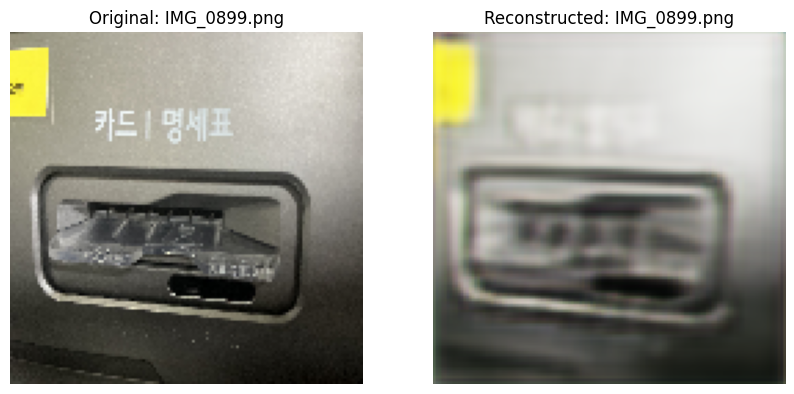

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


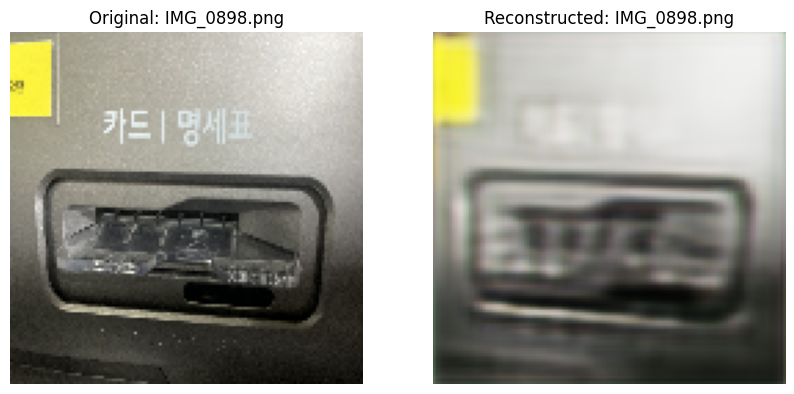

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


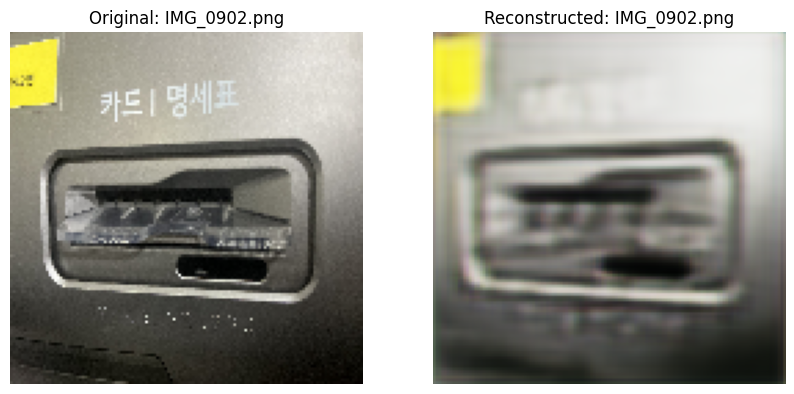

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


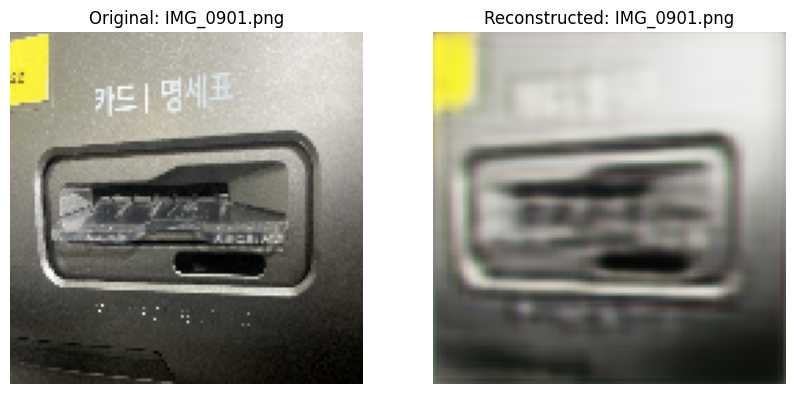

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


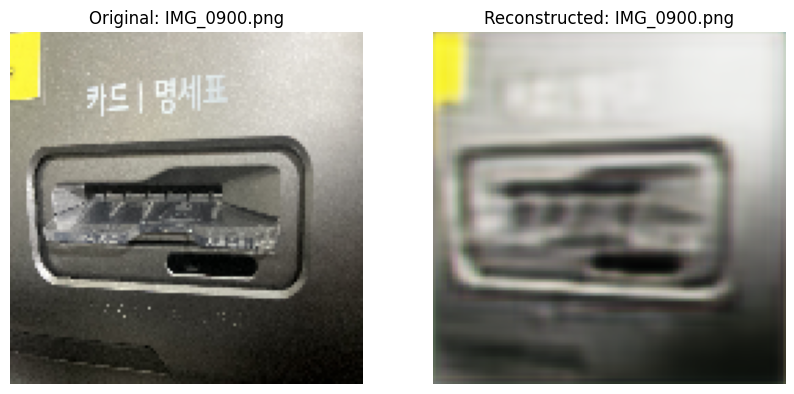

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


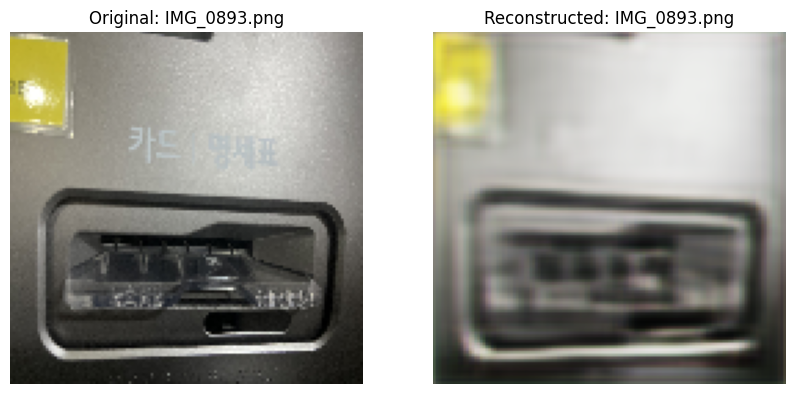

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


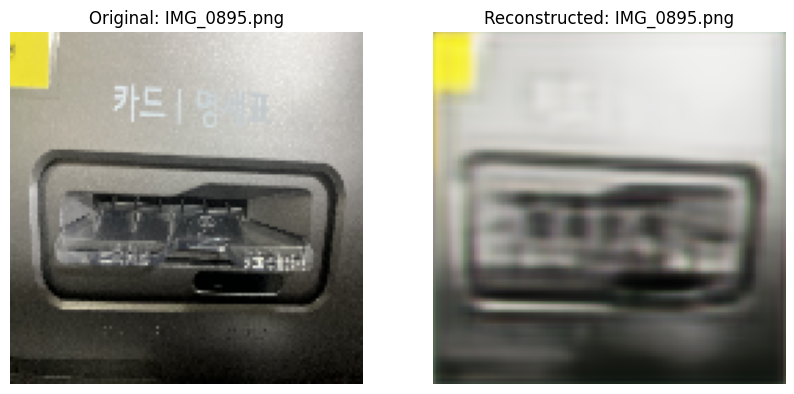

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


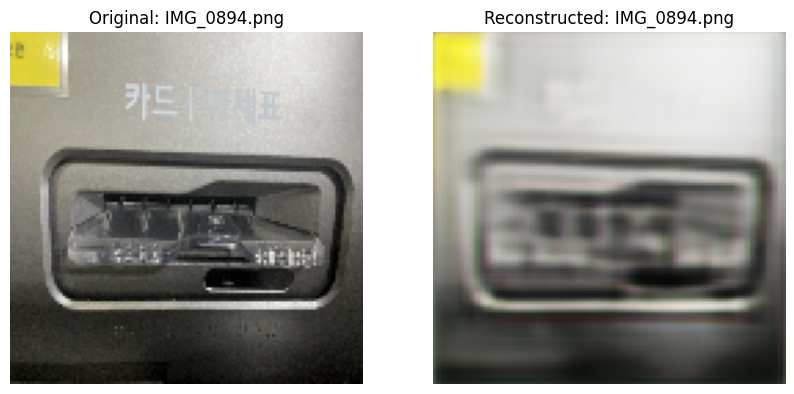

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


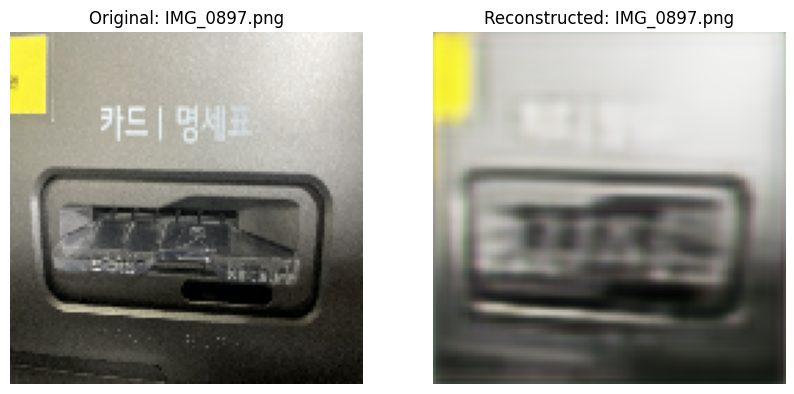

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


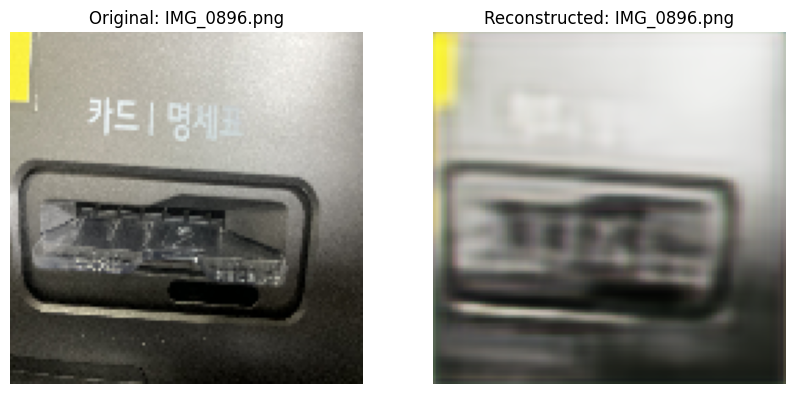

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


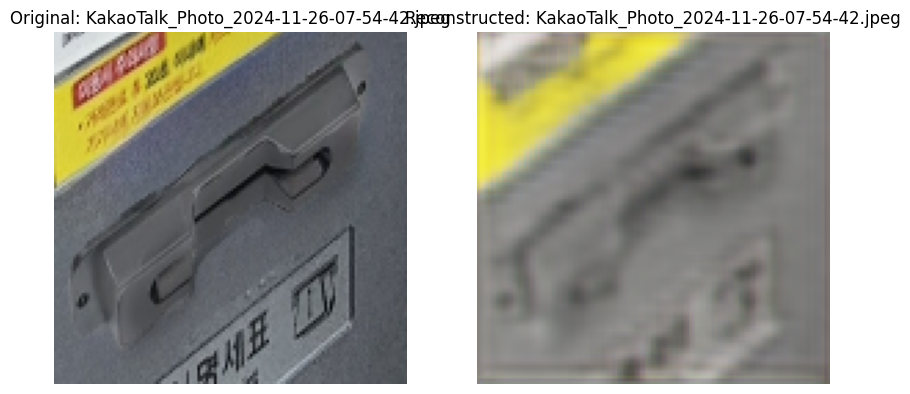

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


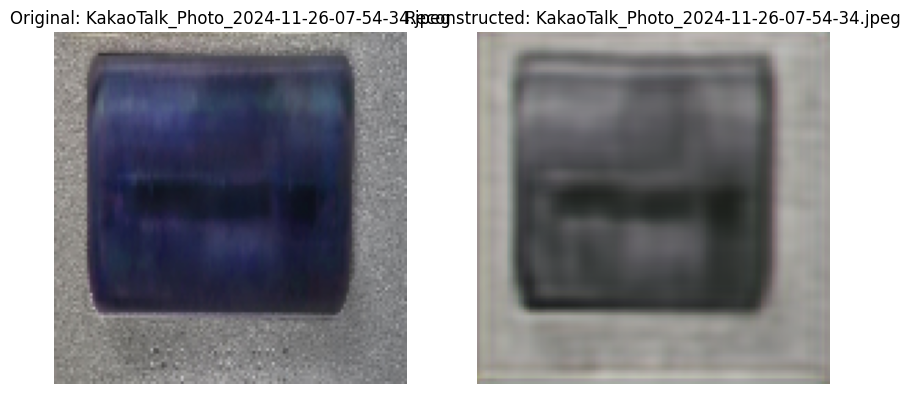

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


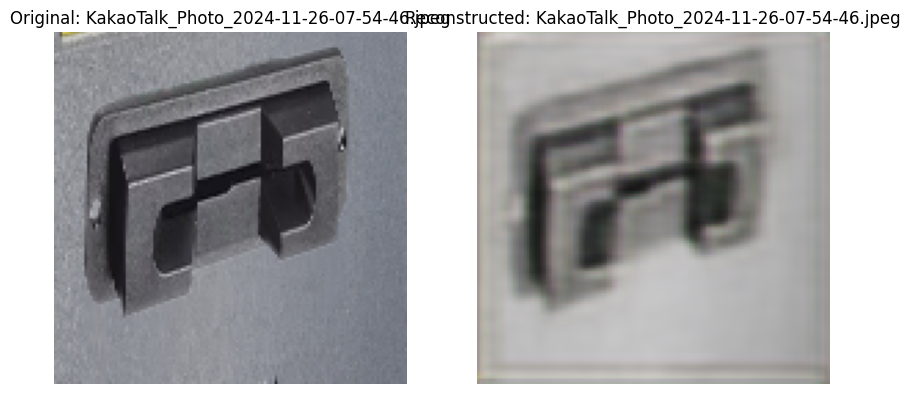

In [55]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 테스트 데이터 경로
test_dataset_path = '/content/drive/MyDrive/test_dir'

# 이미지 파일 리스트 가져오기
test_images = [f for f in os.listdir(test_dataset_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.heic'))]
print(f"Found {len(test_images)} images for testing.")

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 색상 채널 변환
    img = cv2.resize(img, (128, 128))  # 모델에 맞는 크기로 조정
    img = np.array(img) / 255.0  # 0-1 범위로 정규화
    return img

# 테스트 이미지 처리
for test_image in test_images:
    image_path = os.path.join(test_dataset_path, test_image)

    # 이미지를 로드하고 전처리
    img = load_and_preprocess_image(image_path)
    img_batch = np.expand_dims(img, axis=0)  # 배치 차원 추가

    # 모델 예측 (복원된 이미지 계산)
    reconstructed_img = autoencoder.predict(img_batch)

    # 원본 이미지와 복원된 이미지 출력
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # 원본 이미지 출력
    axes[0].imshow(img)
    axes[0].set_title(f"Original: {test_image}")
    axes[0].axis('off')

    # 복원된 이미지 출력
    axes[1].imshow(reconstructed_img[0])  # 배치 차원 제거
    axes[1].set_title(f"Reconstructed: {test_image}")
    axes[1].axis('off')

    plt.show()

In [56]:
import numpy as np

def calculate_reconstruction_error(original, reconstructed):
    """
    원본 이미지와 재구성된 이미지 간의 오류를 계산합니다.
    여기서는 평균 제곱 오차(MSE)를 사용합니다.
    """
    # MSE 계산 (이미지가 float32로 변환되어 있다고 가정)
    return np.mean((original - reconstructed) ** 2)


In [57]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import os


# 훈련 데이터의 평균 재구성 오차와 표준편차를 구해서 임계값 설정
train_reconstruction_errors = []  # 훈련 중 재구성 오차 리스트

for img in X_train:
    reconstructed_img = autoencoder.predict(np.expand_dims(img, axis=0))
    error = np.mean(np.square(img - reconstructed_img[0]))  # MSE 계산
    train_reconstruction_errors.append(error)

# 평균과 표준편차 구하기
mean_error = np.mean(train_reconstruction_errors)
std_error = np.std(train_reconstruction_errors)

# 임계값을 평균 + 2*표준편차로 설정 (재구성 오차가 크게 나올 확률이 낮은 값)
threshold = mean_error + 2 * std_error

def calculate_ssim(original, reconstructed):
    original = (original * 255).astype("uint8")
    reconstructed = (reconstructed * 255).astype("uint8")
    # SSIM 계산 시 win_size=3으로 설정
    score, _ = ssim(original, reconstructed, multichannel=True, full=True, win_size=3)
    return score

for test_image in test_images:
    image_path = os.path.join(test_dataset_path, test_image)

    # 이미지 로드 및 전처리
    img = load_and_preprocess_image(image_path)
    img_batch = np.expand_dims(img, axis=0)  # 배치 차원 추가

    # 복원된 이미지 계산
    reconstructed_img = autoencoder.predict(img_batch)

    # 재구성 오차 (MSE) 계산
    reconstruction_error = calculate_reconstruction_error(img, reconstructed_img[0])

    # SSIM 계산
    ssim_score = calculate_ssim(img, reconstructed_img[0])

    # 이상 여부 판단
    if reconstruction_error > threshold or ssim_score < ssim_threshold:
        print(f"Image {test_image} is Anomalous.")
    else:
        print(f"Image {test_image} is Normal.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━